# Analyse de data-drifting

Création d'un rapport HTML sur des données plus récentes que les données d'entrainement

Test de la connection à l'API sur AWS

https://github.com/evidentlyai/evidently/tree/main/examples#10-minutes-to-evidently

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from tqdm.notebook import trange, tqdm
import time
import requests
import io
import os

from sklearn import pipeline as pip
import pickle
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn
import logging

logging.basicConfig(level=logging.WARN)

from urllib.parse import urlparse
import pkg_resources

from flask import Flask, request, jsonify

## Data drifting :
Mesure effectuée sur un deuxième jeu de données fourni (df_test.csv), l'API que nous avons mis en place enregistre également toutes les prédictions faites depuis le dashboard Streamlit (final_data/model_output.csv). Il sera possible de reconduire l'analyse de data drift sur ces données une fois assez de prédictions effectuées.

In [2]:
df_test = pd.read_csv("final_data/df_test.csv", sep=',').drop(
    columns="Unnamed: 0").dropna()  # données antérieures pour test de drift
data = pd.read_csv("final_data/df_train.csv", sep=',').drop(
    columns="Unnamed: 0")  # données de référence -> celles d'entrainement
cols = df_test.columns
df_test

,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,AMT_INCOME_TOTAL,HOUR_APPR_PROCESS_START,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER
0,0.159520,0.789654,-812,-5170.0,-1740.0,0.018850,135000.0,18,0.0,0
1,0.432962,0.291656,-1623,-9118.0,0.0,0.035792,99000.0,9,3.0,1
2,0.610991,0.699787,-3503,-2175.0,-856.0,0.019101,202500.0,14,4.0,1
3,0.612704,0.509677,-4208,-2000.0,-1805.0,0.026392,315000.0,11,3.0,0
5,0.392774,0.628904,-2027,-6116.0,-1705.0,0.025164,270000.0,15,2.0,0
...,...,...,...,...,...,...,...,...,...,...
48738,0.240541,0.762352,-4178,-174.0,-987.0,0.009175,135000.0,16,2.0,0
48739,0.643026,0.648575,-3399,-9094.0,-684.0,0.002042,121500.0,16,1.0,0
48741,0.283712,0.632770,-1504,-2681.0,-838.0,0.026392,202500.0,12,1.0,0
48742,0.595456,0.445701,-1364,-1461.0,-2308.0,0.018850,225000.0,10,2.0,1


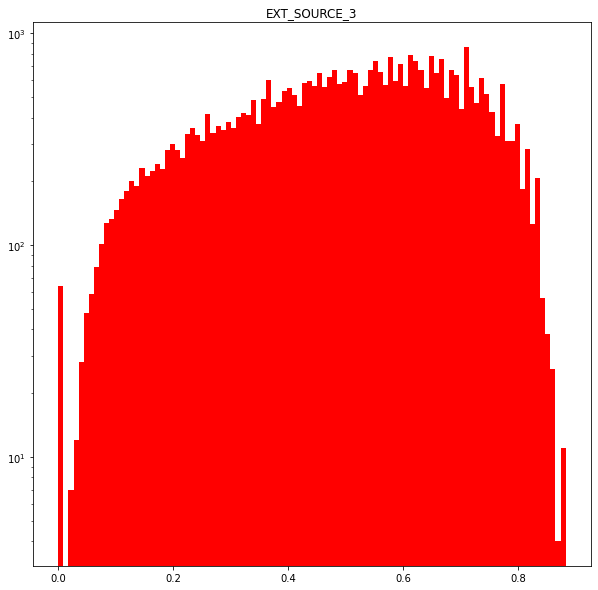

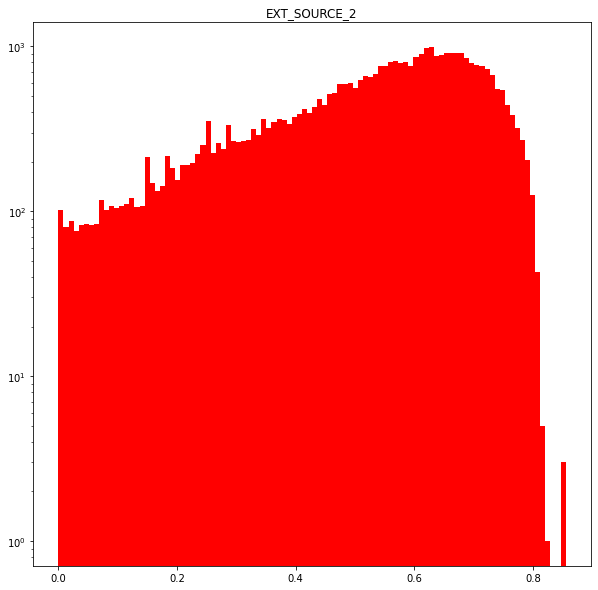

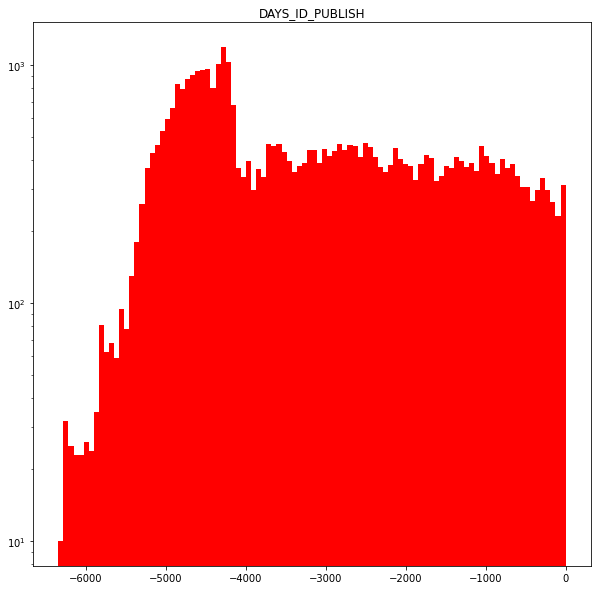

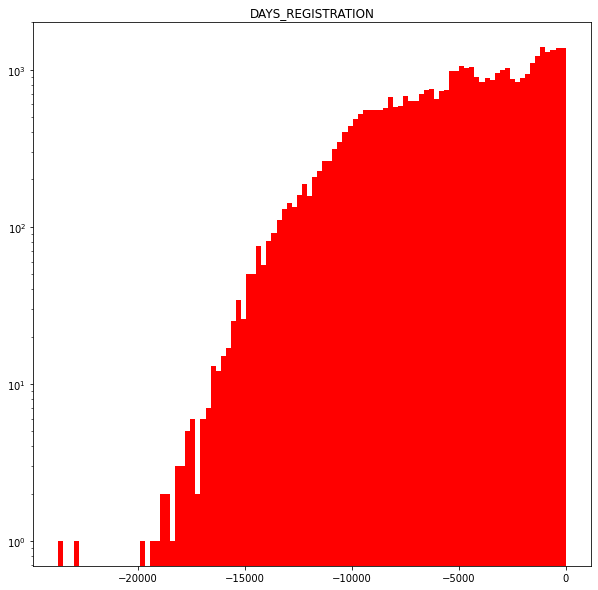

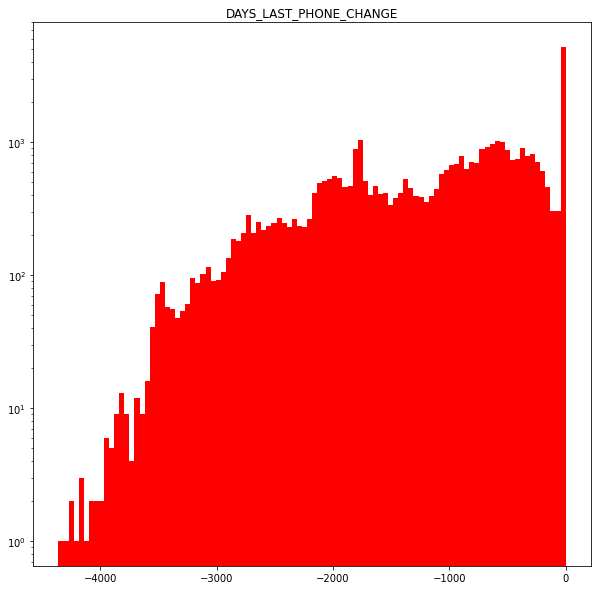

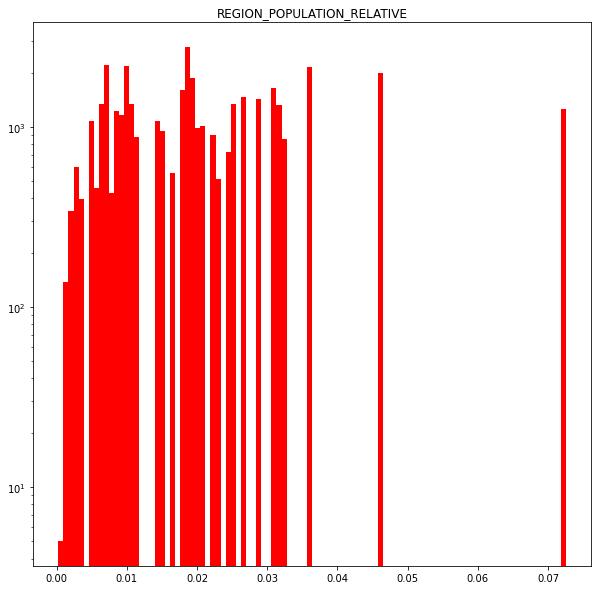

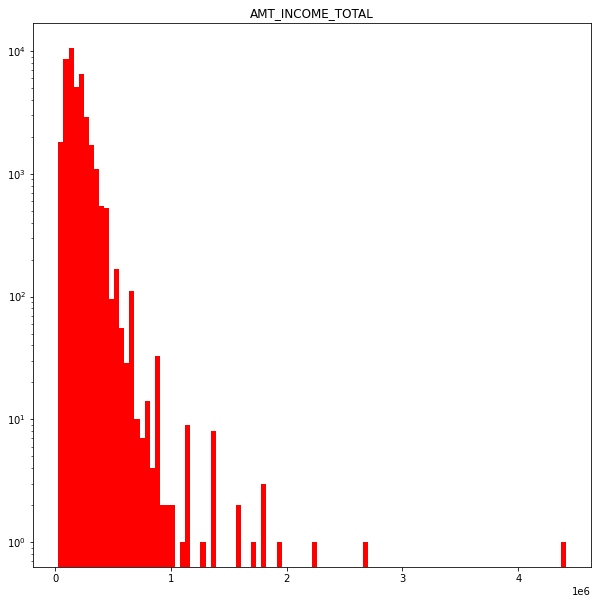

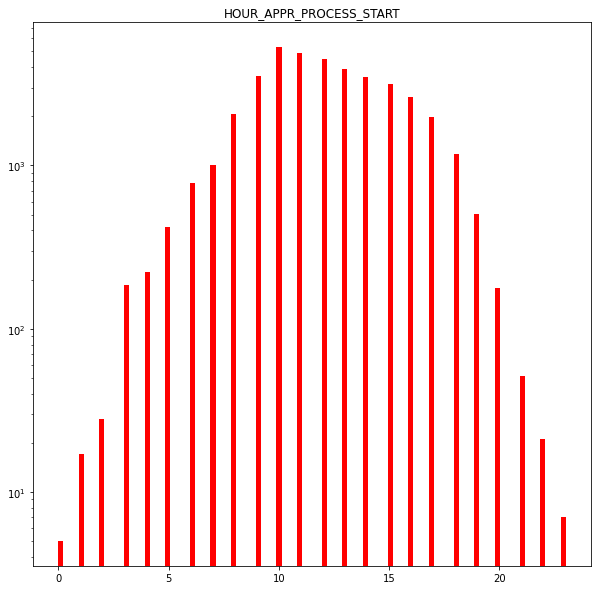

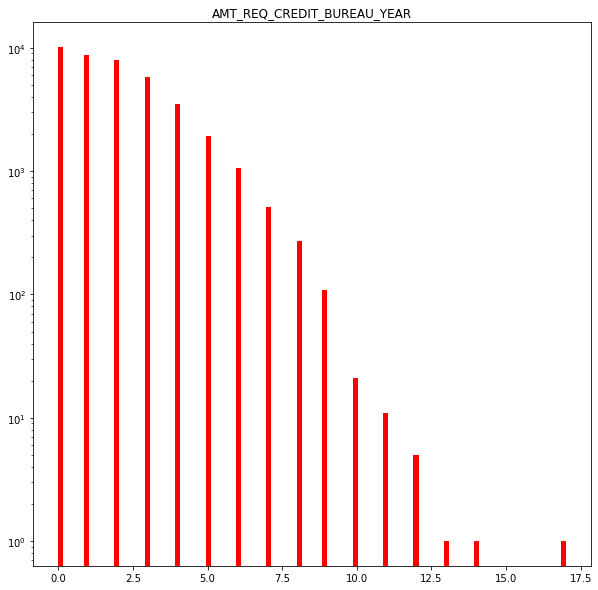

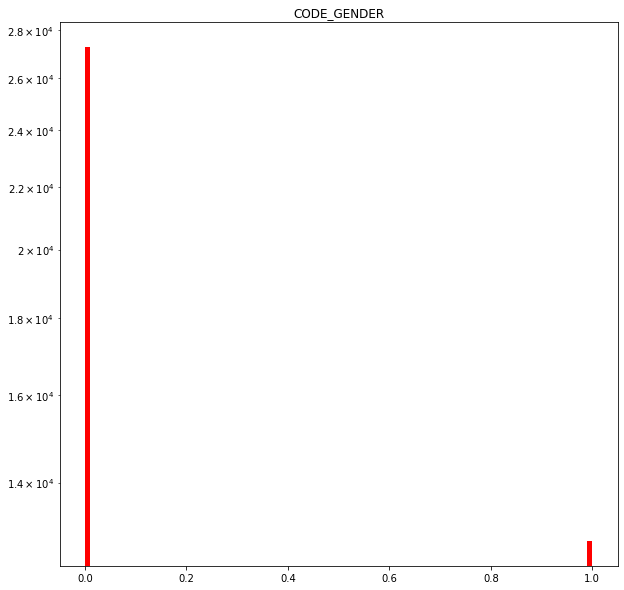

In [3]:
for col in df_test.columns:
    plt.figure(figsize=(10, 10))
    plt.hist(df_test[col], bins=100, color='red', zorder=0,log=True)
    plt.title(col)
    plt.show()
plt.close('all')

In [4]:
df_test=df_test[df_test["AMT_INCOME_TOTAL"]<1000000] # outliers
df_test["AMT_INCOME_TOTAL"].max()

990000.0

In [5]:
with open('pipeline/pipeline.pkl', 'rb') as file:
    ppl = pickle.load(file)

In [6]:
if 'TARGET' in df_test.columns:
    df_test.drop(columns='TARGET', inplace=True)
df_test['TARGET']=ppl.predict(df_test)

/home/camille/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/camille/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/tmp/ipykernel_599120/3194706354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['TARGET']=ppl.predict(df_test)


In [7]:
# from evidently import ColumnMapping

# column_mapping = ColumnMapping()

# column_mapping.target = 'TARGET'
# column_mapping.id = None 

# column_mapping.numerical_features = cols
# column_mapping.categorical_features = "CODE_GENDER"

In [8]:
# from evidently.report import Report
# from evidently.metric_preset import DataDriftPreset
# from evidently.metric_preset import TargetDriftPreset
# from evidently.options import DataDriftOptions

# options = DataDriftOptions(threshold=25)
# drift_report = Report(metrics=[DataDriftPreset(), TargetDriftPreset()], options=options)
# drift_report.run(reference_data=data, current_data=df_test)
# drift_report.save_html("P7_datadrift.html")

In [9]:
data=data[cols]

In [10]:
numcols=data.drop(columns=["CODE_GENDER"]).columns

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from evidently.metric_preset import TargetDriftPreset
from evidently.options import DataDriftOptions
from evidently import ColumnMapping

column_mapping = ColumnMapping()
column_mapping.id = None
column_mapping.numerical_features = cols
column_mapping.categorical_features = ["CODE_GENDER"] 
drift_report = Report(metrics=[DataDriftPreset(), TargetDriftPreset()])

drift_report.column_mapping = column_mapping

drift_report.run(reference_data=data, current_data=df_test)
drift_report.save_html("P7_datadrift.html")
print("done")

/home/camille/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/camille/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/camille/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

done


# Requête à l'API

Test simple du fonctionnement correct du pipeline avant mise en place du dashboard

In [11]:
data=pd.read_csv("final_data/df_train.csv", sep=',').drop(columns='Unnamed: 0')
X=data.drop(columns='TARGET')
X.head()

,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,AMT_INCOME_TOTAL,HOUR_APPR_PROCESS_START,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER
0,0.609276,0.588927,-1247.0,-13169.0,-1626.0,0.007020,157500.0,10.0,2.0,0.0
1,0.659406,0.712589,-4662.0,-9017.0,-3078.0,0.030755,135000.0,13.0,1.0,0.0
2,0.546602,0.724572,-4308.0,-4306.0,-434.0,0.025164,180000.0,10.0,3.0,1.0
3,0.735221,0.588985,-504.0,-1605.0,-295.0,0.024610,202500.0,13.0,2.0,1.0
4,0.334454,0.750144,-3121.0,-12222.0,-2061.0,0.006008,157500.0,9.0,0.0,0.0


## Requête de l'API sur AWS EC2

In [12]:
import requests
import pandas as pd

# adresse de l'instance
url= 'http://ec2-51-20-104-253.eu-north-1.compute.amazonaws.com:5000/home/ubuntu/Projet7_OC/'

data=X.sample(500).to_json()

# Envoyer la requête POST à l'API avec les données au format json
response = requests.post(url, json=data, verify=False )

# Vérifier si la requête a réussi
if response.status_code == 200:
    predictions = response.json()['predictions']
    print('Prédictions :', predictions) 
else:
    print("Erreur lors de l'appel de l'API :", response.text)

Prédictions : [[0.5741976637888524, 0.4258023362111476], [0.39340107394692403, 0.606598926053076], [0.2186138539035949, 0.7813861460964051], [0.5051856990024671, 0.4948143009975329], [0.4514027797723298, 0.5485972202276702], [0.41921516134867054, 0.5807848386513295], [0.5197219821559866, 0.4802780178440134], [0.3731614845989093, 0.6268385154010907], [0.5297794210419902, 0.47022057895800984], [0.7204625653894172, 0.2795374346105827], [0.680747772254257, 0.3192522277457431], [0.8012721524179969, 0.19872784758200313], [0.39469541694706256, 0.6053045830529374], [0.5442005882680138, 0.45579941173198624], [0.2531228428277572, 0.7468771571722428], [0.5981407030736872, 0.40185929692631284], [0.306155974299525, 0.693844025700475], [0.5210880961423808, 0.47891190385761917], [0.29291184303734186, 0.7070881569626581], [0.49374427307099256, 0.5062557269290074], [0.7048908827422606, 0.2951091172577394], [0.32917078271876954, 0.6708292172812305], [0.35416242306650203, 0.645837576933498], [0.799676332

(array([ 3.,  3.,  2.,  2.,  3.,  5.,  3., 14.,  5., 12.,  8., 15., 13.,
         7., 19.,  6., 28.,  8., 26.,  9., 21., 11., 13.,  6., 14., 14.,
        10., 16.,  4., 16.,  8., 22., 10., 11.,  3., 22.,  2., 14., 17.,
         8., 13., 11.,  9.,  2., 10.,  7.,  4.,  4.,  3.,  4.]),
 array([0.1   , 0.1154, 0.1308, 0.1462, 0.1616, 0.177 , 0.1924, 0.2078,
        0.2232, 0.2386, 0.254 , 0.2694, 0.2848, 0.3002, 0.3156, 0.331 ,
        0.3464, 0.3618, 0.3772, 0.3926, 0.408 , 0.4234, 0.4388, 0.4542,
        0.4696, 0.485 , 0.5004, 0.5158, 0.5312, 0.5466, 0.562 , 0.5774,
        0.5928, 0.6082, 0.6236, 0.639 , 0.6544, 0.6698, 0.6852, 0.7006,
        0.716 , 0.7314, 0.7468, 0.7622, 0.7776, 0.793 , 0.8084, 0.8238,
        0.8392, 0.8546, 0.87  ]),
 <BarContainer object of 50 artists>)

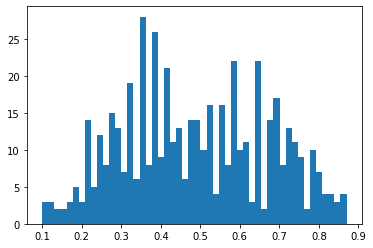

In [13]:
# histogramme pour vérifier la distribution des prédictions
prob0=[]
prob1=[]

for pred in predictions:
    prob0.append(np.round(pred[0],2))
    prob1.append(np.round(pred[1], 2))

plt.hist(prob0, bins=50)